# Image segmentation using U-Net
References:
- [Guide](https://medium.com/@alessandromondin/semantic-segmentation-with-pytorch-u-net-from-scratch-502d6565910a)
- [Handling COCO dataset](https://www.kaggle.com/code/armanasgharpoor1993/coco-dataset-tutorial-image-segmentation)
- [Generating class-wise masks](https://github.com/Tramac/awesome-semantic-segmentation-pytorch/blob/master/core/data/dataloader/mscoco.py)

In [111]:
# Import necessary libraries
import numpy as np
import os, sys 
from importlib import reload
import matplotlib.pyplot as plt
import fiftyone as fo 
import fiftyone.zoo as foz
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset
from  torchvision.transforms import InterpolationMode

from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask

In [56]:
# Load dataset

# Save to current directory
curr_dir = os.getcwd()
fo.config.dataset_zoo_dir = curr_dir 

# Download the data 
dataset = foz.load_zoo_dataset("coco-2017",
                            splits=['train'],
                            shuffle=True,
                            seed=0,
                            max_samples=300,
                            label_type=['segmentations'],
                            only_matching=True,
                            classes=['person', 'cat', 'car'])

Found annotations at '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Segmentation U-Net/coco-2017/raw/instances_train2017.json'
100 images found; downloading the remaining 200
 100% |██████████████████| 200/200 [13.3s elapsed, 0s remaining, 16.4 images/s]      
Writing annotations for 300 downloaded samples to '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Segmentation U-Net/coco-2017/train/labels.json'
Dataset info written to '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Segmentation U-Net/coco-2017/info.json'
Ignoring unsupported parameter 'label_type' for importer type <class 'fiftyone.utils.coco.COCODetectionDatasetImporter'>
Loading 'coco-2017' split 'train'
 100% |█████████████████| 300/300 [581.1ms elapsed, 0s remaining, 516.3 samples/s]      
Dataset 'coco-2017-train-300' created


In [136]:
class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, filter_classes, size=None, max_num=None):
        self.image_dir = image_dir
        self.filter_classes = filter_classes
        self.coco = COCO(annotation_file)
        self.coco_mask = mask 

        # Fetch class IDs only corresponding to the filterClasses
        self.catIds = self.coco.getCatIds(catNms=filter_classes)

        # Get image ID that satisfies the given filter conditions
        self.ids = self.coco.getImgIds()
        
        if max_num != None:
            self.ids = self.ids[:max_num]

        self.size = size
        if size != None:
            self.transform = T.Compose([T.Resize((size, size)), T.ToTensor()])
            self.mask_transform = T.Compose([T.Resize((size, size), interpolation=Image.NEAREST), 
                                             T.ToTensor()])
        else:
            self.transform = T.ToTensor()
            self.mask_transform = T.ToTensor()
        
        self.scale = len(self.catIds)
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.catIds)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        mask = np.zeros(image.size[::-1], dtype=np.uint8)
       
        # 0 is background
        for ann in anns:
            idx = self.catIds.index(ann['category_id']) + 1
            mask = np.maximum(mask, self.coco.annToMask(ann)*idx)

        # Normalize for PyTorch
        mask = Image.fromarray(mask/len(self.catIds))

        
        image = self.transform(image)
        mask = self.mask_transform(mask)
        
        return image, mask

In [137]:
# Dataset loader for PyTorch

dataDir='./coco-2017/'
dataType='train2017'
# annFile='{}raw/instances_{}.json'.format(dataDir, dataType)
annFile='{}/train/labels.json'.format(dataDir)

imageDir = '{}train/data/'.format(dataDir)
filter_classes = ['person', 'cat', 'car']
size = 256
max_num = None

# Initialize the COCO api for instance annotations
coco_dataset = COCODataset(imageDir, annFile, filter_classes, size, max_num)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [138]:
from torch.utils.data import random_split

train_ratio = 0.8
total_length = len(coco_dataset)
print(total_length)
train_length = int(train_ratio * total_length)
test_length = total_length - train_length

train_dataset, test_dataset = random_split(coco_dataset, [train_length, test_length])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(len(train_loader), len(test_loader))

300
60 60


In [149]:

class UNetBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, submodule, kernel=4, stride=2, padding=1, 
                 dropout = False, outermost = False, innermost = False):
        super(UNetBlock, self).__init__()

        down_conv = nn.Conv2d(in_channels, mid_channels, kernel_size=kernel, stride=stride, padding=padding)
        down_batchnorm = nn.BatchNorm2d(mid_channels)
        down_relu = nn.ReLU(inplace=True)
        up_batchnorm = nn.BatchNorm2d(out_channels)
        up_relu = nn.ReLU(inplace=True)

        self.outermost = outermost 

        if outermost:
            layers = [down_conv, down_batchnorm, down_relu]
            layers += [submodule]
            layers += [nn.ConvTranspose2d(mid_channels*2, out_channels, kernel_size=kernel, stride=stride, padding=padding)]
            # ## Add final activation - segmentation uses sigmoid
            # layers += [nn.Sigmoid()]
            layers += [nn.Softmax(dim=1)]
        elif innermost:
            up_conv = nn.ConvTranspose2d(mid_channels, out_channels, kernel_size=kernel, stride=stride, padding=padding)
            layers = [down_conv, down_batchnorm, down_relu]
            layers += [up_conv, up_batchnorm, up_relu]
        else: 
            up_conv = nn.ConvTranspose2d(mid_channels*2, out_channels, kernel_size=kernel, stride=stride, padding=padding)
            layers = [down_conv, down_batchnorm, down_relu]
            layers += [submodule]
            layers += [up_conv, up_batchnorm, up_relu]
            if dropout: layers += [nn.Dropout(0.4)]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], axis = 1)

class UNet(nn.Module):
    # Exit channels is number of classes
    def __init__(self, in_channels, first_out_channels, exit_channels, downhill = 4, kernel = 3, stride = 1, padding = 0):
        super(UNet, self).__init__()
        
        num_innermost = first_out_channels*(2**(downhill - 1))
        num_mid = num_innermost
        layer = UNetBlock(num_innermost, num_innermost, num_innermost, None, innermost=True)
        for _ in range(downhill - 1):
            num_mid //= 2
            layer = UNetBlock(num_mid, num_mid*2, num_mid, layer)
            
        self.model = UNetBlock(in_channels, first_out_channels, exit_channels, layer, outermost=True)

    def forward(self, x):
        return self.model(x)
        

In [156]:
# Parameters
batch_size = 16
learning_rate = 2e-3
num_epochs = 10
n_down = 2
input_channels = 3
first_out_channels = 32
output_classes = 4
device = torch.device('mps')

# 4 classes output - person, cat, car, background
model = UNet(input_channels, first_out_channels, output_classes, n_down)
# model = UNet(input_channels, output_classes)

# Define loss function
# criterion = nn.CrossEntropyLoss()  # You can change to Dice Loss or other appropriate loss
criterion = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='focal_loss',
	alpha=torch.tensor([0.1, 0.3, 0.3, 0.3]),
	gamma=0,
    device=device,
	reduction='mean',
	force_reload=False
)
 
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set device
model.to(device)


Using cache found in /Users/sudhansh/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


UNet(
  (model): UNetBlock(
    (model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): UNetBlock(
        (model): Sequential(
          (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): UNetBlock(
            (model): Sequential(
              (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (

In [157]:
# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, masks) in tqdm(enumerate(train_loader)):
        images, masks = images.to(device), masks.to(device)

        # Convert to int masks
        masks = masks*coco_dataset.scale 
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        flattened_output = outputs.reshape([batch_size, output_classes, -1])
        flattened_masks = masks.reshape([batch_size, -1]).long()
        loss = criterion(flattened_output, flattened_masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(coco_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

60it [00:06,  9.22it/s]


Epoch [1/10], Loss: 0.152259


60it [00:05, 10.25it/s]


Epoch [2/10], Loss: 0.151871


60it [00:05, 10.49it/s]


Epoch [3/10], Loss: 0.151715


60it [00:05, 10.13it/s]


Epoch [4/10], Loss: 0.151601


60it [00:05, 10.61it/s]


Epoch [5/10], Loss: 0.151554


60it [00:05, 10.25it/s]


Epoch [6/10], Loss: 0.151511


60it [00:05, 10.27it/s]


Epoch [7/10], Loss: 0.151483


60it [00:05, 10.34it/s]


Epoch [8/10], Loss: 0.151375


60it [00:05, 10.40it/s]


Epoch [9/10], Loss: 0.151394


60it [00:05, 10.49it/s]

Epoch [10/10], Loss: 0.151345


In [71]:
# Save model for using trained weights in the future
torch.save(model.state_dict(), 'trained.pt')

In [152]:
print(images.shape)
image = images[0, ...].permute([1, 2, 0]).cpu()
print(masks.shape)
mask = masks[0, ...].reshape(size, size).cpu()
print(outputs[0, ...].shape)
output = torch.argmax(outputs, dim = 1)
gimage = image[:, :, 0] * 0.2989 + image[:, :, 1] * 0.5870 + image[:, :, 2] * 0.1140
output = output[0, ...].reshape(size, size).cpu()
print(gimage.shape, mask.shape, output.shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 256, 256])
torch.Size([256, 256]) torch.Size([256, 256]) torch.Size([256, 256])


In [ ]:
def metrics(pred_mask, true_mask):
    intersection = torch.sum(pred_mask & true_mask).item()
    union = torch.sum(pred_mask, true_mask).item()
    sum_areas = torch.sum(pred_mask).item() + torch.sum(true_mask).item()

    dice_score = (2*intersection)/(sum_areas)
    iou_score = intersection/union 
    return dice_score, iou_score 

In [ ]:
# Test model 
model.eval()
classes = {0: "background", 1: "person", 2: "car", 3: "cat"}
dice_sums = [[]]*len(classes)
iou_sums = [[]]*len(classes)

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

        for key, value in classes.items():
            class_pred = predicted_masks == key
            class_truth = masks == key
            dice, iou = metrics(class_pred, class_truth)
            dice_sums[key].append(dice) 
            iou_sums[key].append(iou) 
    
mean_dice = [np.mean(scores) for scores in dice_sums]
mean_iou = [np.mean(iou) for scores in iou_sums]


In [ ]:
for key, value in classes.items():
    print("Mean dice score in test cases for", value, "is", mean_dice[key])
    print("Mean IoU score in test cases for", value, "is", mean_iou[key])


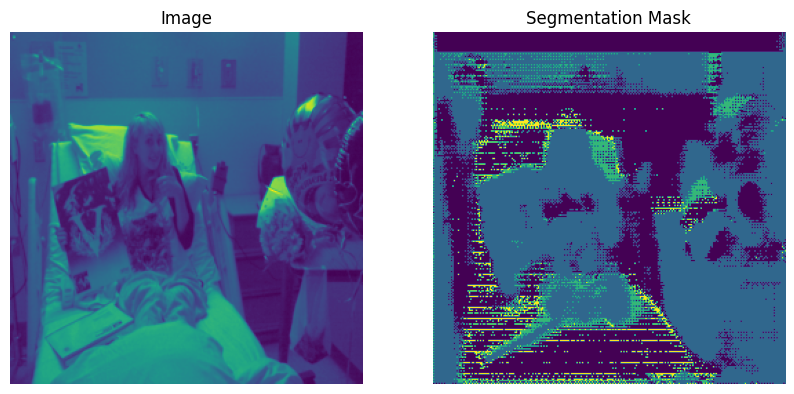

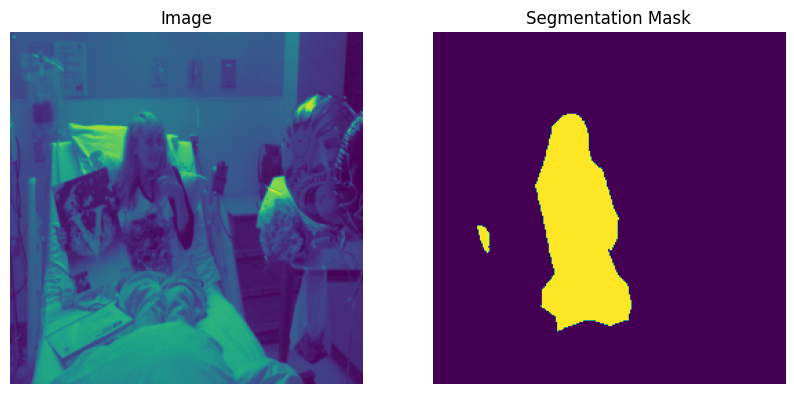

In [158]:
def visualize_segmentation(image, mask, classes=None):
    """
    Visualizes an image and its corresponding segmentation mask.
    
    Parameters:
        image (numpy.ndarray): Input image.
        mask (numpy.ndarray): Segmentation mask.
        classes (list): List of class labels. If provided, the mask will be color-coded accordingly.
    """
    plt.figure(figsize=(10, 5))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Plot the segmentation mask
    plt.subplot(1, 2, 2)
    if classes:
        colored_mask = np.zeros_like(mask, dtype=np.uint8)
        for i, label in enumerate(classes):
            colored_mask[mask == i] = label
        plt.imshow(colored_mask)
        plt.title('Segmentation Mask (Color-coded)')
    else:
        plt.imshow(mask)
        plt.title('Segmentation Mask')
    plt.axis('off')

    plt.show()

# Visualize the image and mask
visualize_segmentation(gimage, output)
visualize_segmentation(gimage, mask)

In [155]:
print(np.unique(masks[0, ...].cpu().numpy()))
print(np.unique(output.cpu().numpy()))

[0. 1.]
[0 1 2 3]
